# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import io


# Зчитуємо завантажений файл у DataFrame
from google.colab import files
uploaded = files.upload()

# список завантажених файлів
print("Список завантажених файлів:")
print(uploaded.keys())

Saving bikes_rent.csv to bikes_rent.csv
Список завантажених файлів:
dict_keys(['bikes_rent.csv'])


Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Зчитуємо завантажений файл у DataFrame
df = pd.read_csv(io.BytesIO(uploaded['bikes_rent.csv']))
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,10.486773,2114
727,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,4.656485,3095
728,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,3.725374,1341
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372,1796


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

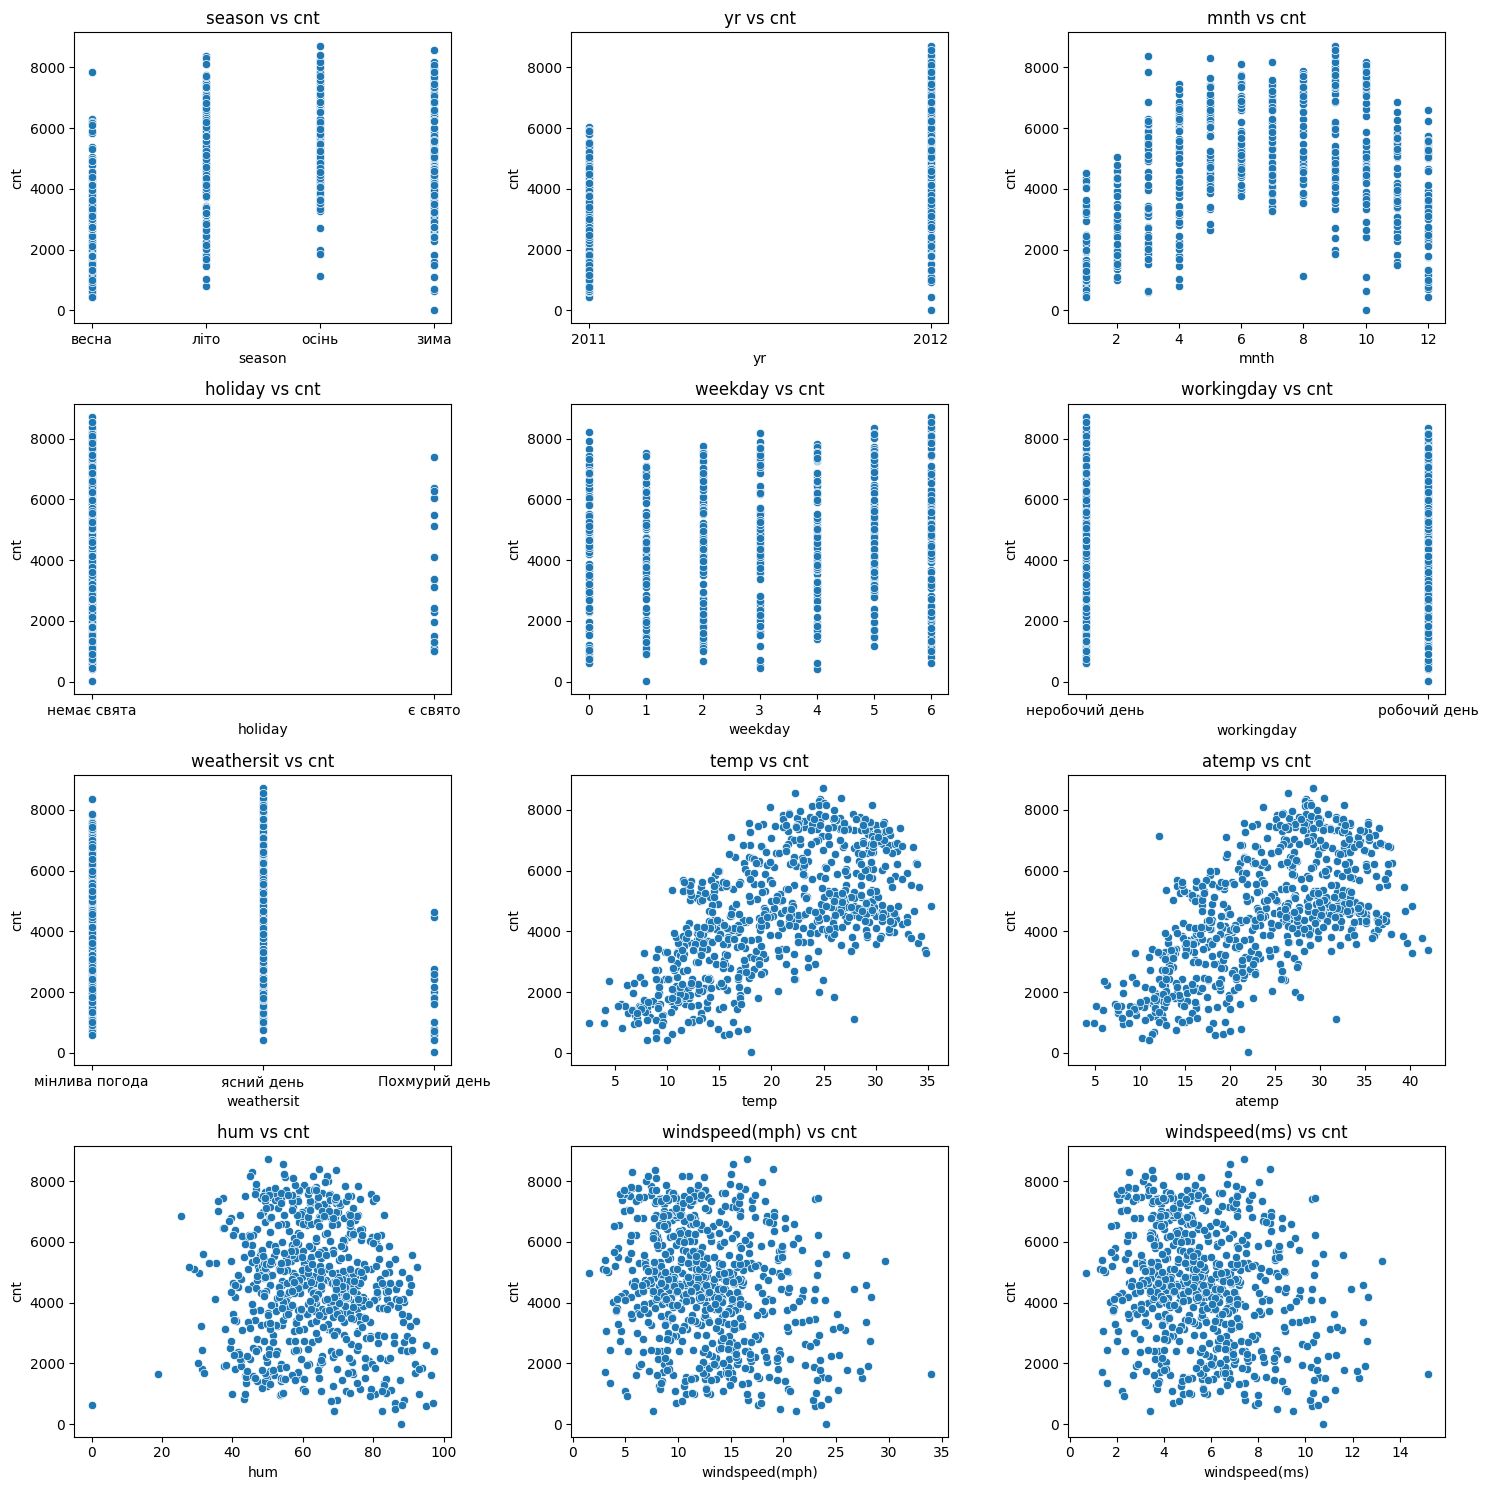

In [5]:
# Створюємо підграфіки 4x3
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
df_cor = df.copy()
df_cor['season'] = df_cor['season'].replace({1: 'весна', 2: 'літо', 3: 'осінь', 4: 'зима'})
df_cor['yr'] = df_cor['yr'].replace({0: '2011', 1: '2012'})
df_cor['holiday'] = df_cor['holiday'].replace({0: 'немає свята', 1: 'є свято'})
df_cor['workingday'] = df_cor['workingday'].replace({0: 'неробочий день', 1: 'робочий день'})
df_cor['weathersit'] = df_cor['weathersit'].replace({1: 'ясний день', 2: 'мінлива погода', 3: 'Похмурий день', 4: 'злива, туман'})
# Перебираємо стовпці, крім "cnt"
for i, column in enumerate(df.columns[:-1]):
    # Розраховуємо рядок та стовпець для поточного підграфіка
    row = i // 3
    col = i % 3
    # Побудова графіка
    sns.scatterplot(x=column, y='cnt', data=df_cor, ax=axes[row, col])
    axes[row, col].set_title(f'{column} vs cnt')

# Відображення графіків
plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Яким є характер залежності кількості прокатів від місяця? Відповідь: Кількість прокатів є найбільшою в період від травня до жовтня (пік - жовтень). Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. Відповідь: Ознаки: temp та atemp (температура).

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [6]:
# Обчислюємо кореляцію Пірсона між числовими ознаками та цільовою змінною 'cnt'
correlation_with_cnt = df.iloc[:, :-1].corrwith(df['cnt'])

# Виводимо кореляції
print("Кореляція між числовими ознаками та цільовою змінною 'cnt':")
print(correlation_with_cnt)

Кореляція між числовими ознаками та цільовою змінною 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [7]:
# Вибираємо необхідні ознаки
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислюємо кореляцію між вибраними ознаками
correlation_matrix = df[features].corr()

# Виводимо матрицю кореляцій
print("Матриця кореляцій:")
correlation_matrix

Матриця кореляцій:


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [8]:
# Виведення середніх значень ознак
means = df.mean()

# Вивід середніх значень
print("Середні значення ознак:")
means

Середні значення ознак:


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [14]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
#print(type(X))
df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,3,0,0,0,1,15.758268,19.00455,52.7391,18.130468,8.104814,2417
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
270,4,0,9,0,3,1,2,26.035000,28.75790,84.8750,9.958143,4.451561,3907
435,1,1,3,0,0,0,1,14.831299,17.98350,47.6957,14.913329,6.666665,4911


In [15]:
X

array([[ 1.354375  ,  0.99863295,  1.58866019, ...,  0.74372737,
        -0.21121111, -0.21121111],
       [-1.34821315, -1.00136893, -1.31026791, ..., -1.33538868,
         1.12681211,  1.12681211],
       [ 1.354375  , -1.00136893,  1.00887457, ..., -0.29551449,
         0.50349108,  0.50349108],
       ...,
       [ 1.354375  , -1.00136893,  0.71898176, ...,  1.55169951,
        -0.5404777 , -0.5404777 ],
       [-1.34821315,  0.99863295, -1.0203751 , ..., -1.06046036,
         0.41449871,  0.41449871],
       [-0.44735043, -1.00136893, -0.73048229, ...,  1.34385394,
         0.77643372,  0.77643372]])

In [16]:
y

703    6606
33     1550
300    3747
456    6041
633    7538
       ... 
71     2417
106    3744
270    3907
435    4911
102    2162
Name: cnt, Length: 731, dtype: int64

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [20]:
#from sklearn.linear_model import LinearRegression
# Створюємо та навчаємо модель лінійної регресії
#model = LinearRegression()
#model.fit(X, y)

# Перетворюємо X у DataFrame
#X_df = pd.DataFrame(X, columns=['season', 'yr','mnth', 'holiday','weekday', 'workingday','weathersit', 'temp','atemp', 'hum','windspeed(mph)', 'windspeed(ms)'])  # назви ознак

# Виводимо ваги ознак
#weights = pd.DataFrame({'Feature': X_df.columns, 'Weight': model.coef_})
#print("Ваги ознак:")
#weights

Ваги ознак:


,Feature,Weight
0,season,5.708638e+02
1,yr,1.021965e+03
2,mnth,-1.413017e+02
3,holiday,-8.675934e+01
4,weekday,1.372251e+02
5,workingday,5.639188e+01
6,weathersit,-3.302265e+02
7,temp,3.674837e+02
8,atemp,5.855494e+02
9,hum,-1.456143e+02


In [83]:
X_df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1.354375,0.998633,1.588660,-0.171981,-0.497782,0.679706,-0.726048,-0.106884,-0.032545,0.743727,-0.211211,-0.211211
1,-1.348213,-1.001369,-1.310268,-0.171981,0.500513,0.679706,-0.726048,-1.686082,-1.820550,-1.335389,1.126812,1.126812
2,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491
3,-0.447350,0.998633,-0.730482,-0.171981,-1.496077,-1.471225,1.110427,-0.380219,-0.350427,0.339741,-0.235254,-0.235254
4,1.354375,0.998633,0.718982,-0.171981,-0.497782,0.679706,-0.726048,0.298565,0.428770,-0.406755,0.591838,0.591838
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,-1.001369,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.607005,-0.578834,-0.706119,1.034514,1.034514
727,-0.447350,-1.001369,-0.730482,-0.171981,-1.496077,-1.471225,-0.726048,-0.211658,-0.175978,-1.042010,1.459229,1.459229
728,1.354375,-1.001369,0.718982,-0.171981,0.001366,0.679706,1.110427,0.763234,0.619000,1.551700,-0.540478,-0.540478
729,-1.348213,0.998633,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.730601,-0.704232,-1.060460,0.414499,0.414499


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [25]:
from sklearn.linear_model import LinearRegression
# Розділяємо ознаки та цільову змінну
#X = df.drop(columns=['cnt'])  # Ознаки
#y = df['cnt']  # Цільова змінна

# Створюємо та навчаємо модель лінійної регресії на всіх даних
model = LinearRegression()
model.fit(X, y)

# Перетворюємо X у DataFrame
X_df = pd.DataFrame(X, columns=['season', 'yr','mnth', 'holiday','weekday', 'workingday','weathersit', 'temp','atemp', 'hum','windspeed(mph)', 'windspeed(ms)'])  # назви ознак
# Виводимо ваги моделі (пари (назва ознаки, вага))
weights = list(zip(X_df.columns, model.coef_))
print("Ваги моделі:")
for feature, weight in weights:
    print(f"{feature}: {weight}")

Ваги моделі:
season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


In [82]:
X_df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1.354375,0.998633,1.588660,-0.171981,-0.497782,0.679706,-0.726048,-0.106884,-0.032545,0.743727,-0.211211,-0.211211
1,-1.348213,-1.001369,-1.310268,-0.171981,0.500513,0.679706,-0.726048,-1.686082,-1.820550,-1.335389,1.126812,1.126812
2,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491
3,-0.447350,0.998633,-0.730482,-0.171981,-1.496077,-1.471225,1.110427,-0.380219,-0.350427,0.339741,-0.235254,-0.235254
4,1.354375,0.998633,0.718982,-0.171981,-0.497782,0.679706,-0.726048,0.298565,0.428770,-0.406755,0.591838,0.591838
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,-1.001369,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.607005,-0.578834,-0.706119,1.034514,1.034514
727,-0.447350,-1.001369,-0.730482,-0.171981,-1.496077,-1.471225,-0.726048,-0.211658,-0.175978,-1.042010,1.459229,1.459229
728,1.354375,-1.001369,0.718982,-0.171981,0.001366,0.679706,1.110427,0.763234,0.619000,1.551700,-0.540478,-0.540478
729,-1.348213,0.998633,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.730601,-0.704232,-1.060460,0.414499,0.414499


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [30]:
from sklearn.linear_model import Lasso
# Створюємо та навчаємо модель лінійної регресії з L1-регуляризацією
lasso_model = Lasso()
lasso_model.fit(X, y)

# Виводимо ваги моделі
#weights = list(zip(X_df.columns, lasso_model.coef_))
print("Ваги моделі з L1-регуляризацією (Lasso):")
#for feature, weight in weights:
#    print(f"{feature}: {weight}")
weights_L1 = pd.DataFrame({'Feature': X_df.columns, 'Weight': lasso_model.coef_})
weights_L1

Ваги моделі з L1-регуляризацією (Lasso):


,Feature,Weight
0,season,5.602416e+02
1,yr,1.019463e+03
2,mnth,-1.287306e+02
3,holiday,-8.615278e+01
4,weekday,1.373479e+02
5,workingday,5.521237e+01
6,weathersit,-3.323699e+02
7,temp,3.763632e+02
8,atemp,5.765308e+02
9,hum,-1.441292e+02


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [31]:
from sklearn.linear_model import Ridge
# Створюємо та навчаємо модель лінійної регресії з L2-регуляризацією
ridge_model = Ridge()
ridge_model.fit(X, y)

# Виводимо ваги моделі
#weights = list(zip(X_df.columns, ridge_model.coef_))
print("Ваги моделі з L2-регуляризацією (Ridge):")
#for feature, weight in weights:
#    print(f"{feature}: {weight}")
weights_L2 = pd.DataFrame({'Feature': X_df.columns, 'Weight': ridge_model.coef_})
weights_L2

Ваги моделі з L2-регуляризацією (Ridge):


,Feature,Weight
0,season,563.064572
1,yr,1018.948379
2,mnth,-131.873320
3,holiday,-86.746098
4,weekday,138.005111
5,workingday,55.903110
6,weathersit,-332.349788
7,temp,386.457889
8,atemp,566.347047
9,hum,-145.071327


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [34]:
# Задані значення коефіцієнта alphas
alphas = np.arange(1, 500, 50)

# Створення списків для зберігання ваг Lasso та Ridge регресорів
coefs_lasso = []
coefs_ridge = []
g = 0
for alpha in alphas:
    if g != 1:
      print(f"alphas : {alphas}")
      g = 1
    # Навчання Lasso регресора
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)   # lasso.coef_ - коефіцієнти моделі Lasso після її навчання

    # Навчання Ridge регресора
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Конвертація списків в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print('coefs_lasso')
coefs_lasso

alphas : [  1  51 101 151 201 251 301 351 401 451]
coefs_lasso


array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80514042e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29892889e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41657943e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62789872e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

In [35]:
print('coefs_ridge')
coefs_ridge

coefs_ridge


array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

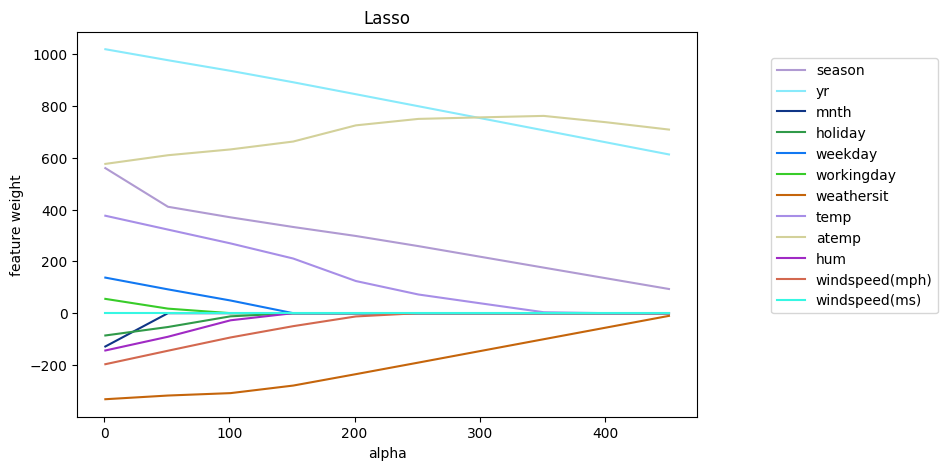

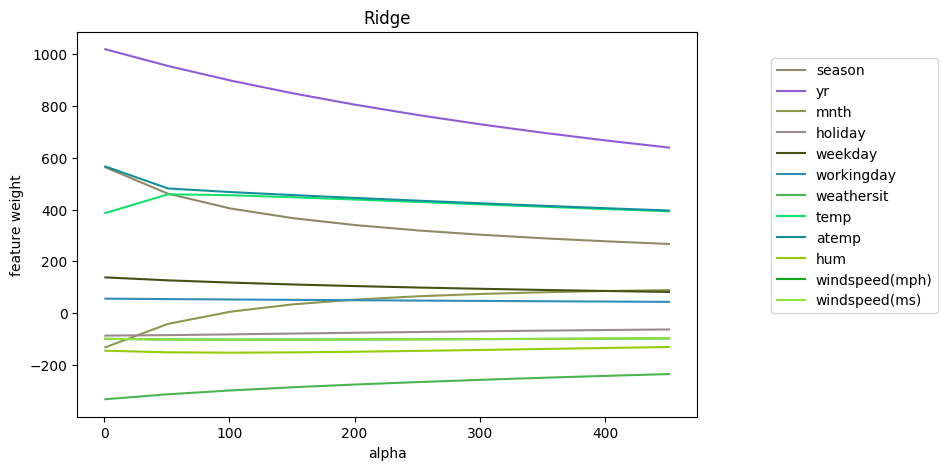

In [36]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповідь:
1.Якщо регуляризатор зменшує ваги більше при однаковому alpha, то він вважається більш агресивним.
З аналізу графіків ваг для Lasso та Ridge при різних значеннях alpha можна визначити, який регуляризатор агресивніше зменшує ваги
2.При збільшенні alpha у Lasso регуляризаторі ваги будуть дедалі більше наближатися до нуля. Це відбувається через те, що Lasso
використовує L1-регуляризацію, яка має тенденцію зануляти незначущі ваги. Чим більше alpha, тим сильніше змінюються ваги.
3.Lasso може виключити одну з ознак (наприклад, windspeed) при будь-якому значенні alpha > 0, оскільки вона може бути менш
важливою з точки зору моделі. У випадку з Ridge регуляризатором, він не виключить цю ознаку повністю, але може значно зменшити її вагу.
4.Lasso є більш підходящим для відбору неінформативних ознак через те, що він здатний занулювати ваги ознак, тоді як
Ridge зменшує їх вагу, але не занулює. Таким чином, Lasso дозволяє більш ефективно виключати неінформативні ознаки.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

alphas : [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96]
mse_values : [849649.73155801 843691.16429991 837882.44671945 832272.33928464
 826999.86451045 822020.59189502 817368.32900859 813002.74003621
 808960.22394727 805282.39802581 801969.26121704 799020.79953995
 796437.0012671  794213.32623068 792107.50817215 790123.42637334
 787952.51271484 785590.79391005 783123.8359058  783011.38118895]


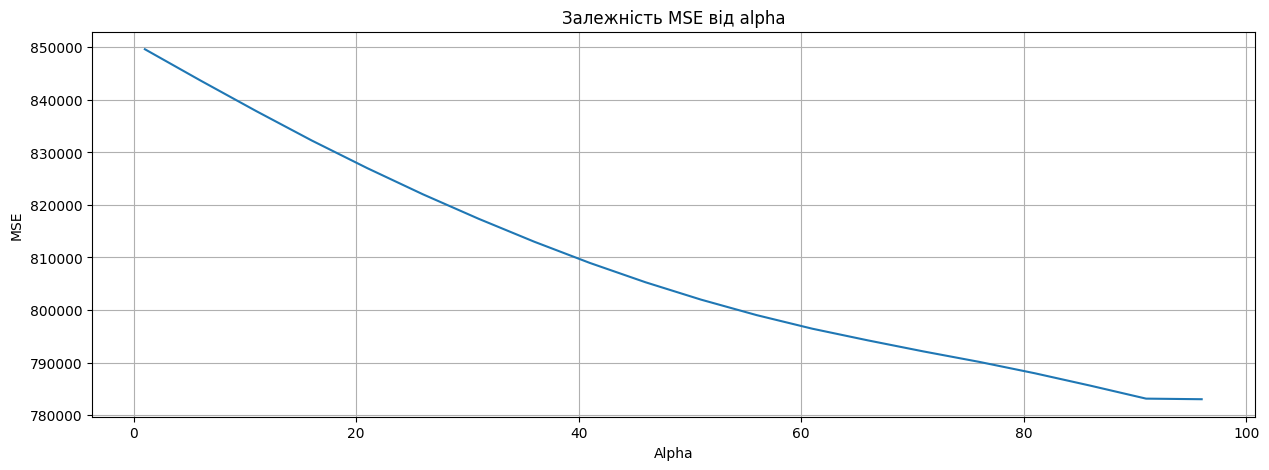

Вибране alpha: 1
Пари 'ознака-коефіцієнт':


{'season': 560.2416160308861,
 'yr': 1019.4634940657196,
 'mnth': -128.73062703678696,
 'holiday': -86.15278133371106,
 'weekday': 137.34789390496314,
 'workingday': 55.21237064135668,
 'weathersit': -332.3698569623487,
 'temp': 376.3632362096943,
 'atemp': 576.530793504555,
 'hum': -144.12915500348583,
 'windspeed(mph)': -197.1396894024843,
 'windspeed(ms)': -2.8051404183533485e-08}

In [91]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # Замість використання map, створіть списки x та y
    x = [e[0] for e in data]
    y = [e[1] for e in data]

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

# Ініціалізація регресора LassoCV зі списком параметрів регуляризації alphas
alphas = np.arange(1, 100, 5)
model = LassoCV(alphas=alphas)
print(f"alphas : {alphas}")
# Навчання моделі на даних
model.fit(X, y)

# Отримання середнього квадратичного помилок (MSE) для кожного значення альфа
mse_values = model.mse_path_.mean(axis=1)
print(f"mse_values : {mse_values}")
# Створення списків зі значеннями alphas і mse_values
x_values = list(alphas)
y_values = mse_values.tolist()  # перетворення на список

# Перетворення zip у список
data_list = list(zip(x_values, y_values))

# Побудова графіка залежності MSE від alpha
create_plot(data_list, "Залежність MSE від alpha", "Alpha", "MSE")

# Виведення вибраного alpha
print("Вибране alpha:", model.alpha_)

# Виведення пар "ознака-коефіцієнт" для навченого вектора коефіцієнтів
features=['season', 'yr','mnth', 'holiday','weekday', 'workingday','weathersit', 'temp','atemp', 'hum','windspeed(mph)', 'windspeed(ms)']
coefficients = dict(zip(features, model.coef_))
print("Пари 'ознака-коефіцієнт':")
coefficients

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


min_indices : [17, 19, 14, 15]
min_alphas : [86, 96, 71, 76]
Значення альфа, що відповідають мінімальній MSE для кожного розділення:
Розділення (Split) 1: альфа: 86
Розділення (Split) 2: альфа: 96
Розділення (Split) 3: альфа: 71
Розділення (Split) 4: альфа: 76


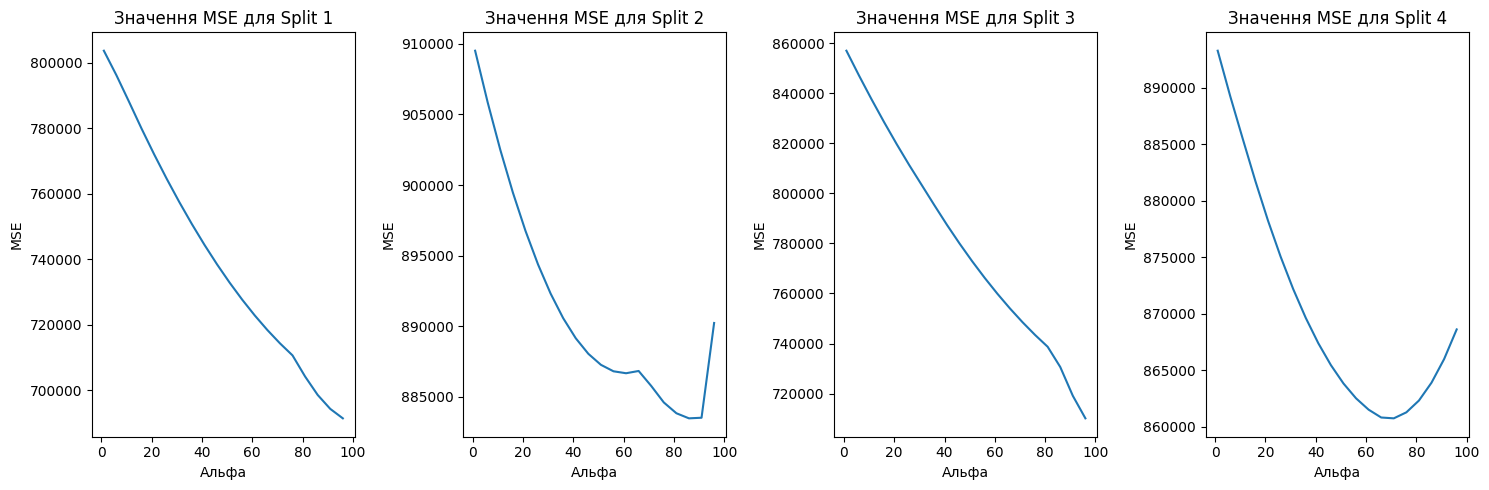

In [58]:
import numpy as np

# Отримання індексів мінімальних значень MSE на кожному розбитті
min_indices = []
min_indices0 = np.argmin(model.mse_path_, axis=0)
#Прибираємо можливі повтори розбиття
for i, min_indices5 in enumerate(min_indices0):
  if i > 0:
    if min_indices5 != min_indices0[i-1]:
        min_indices.append(min_indices5)
print(f"min_indices : {min_indices}")
# Виведення відповідних значень альфа для цих індексів
min_alphas = [alphas[i] for i in min_indices]
print(f"min_alphas : {min_alphas}")
print("Значення альфа, що відповідають мінімальній MSE для кожного розділення:")
for i, alpha in enumerate(min_alphas):
    print(f"Розділення (Split) {i+1}: альфа: {alpha}")

# Побудова п'яти окремих графіків для стовпців mse_path_
plt.figure(figsize=(15, 5))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(alphas, model.mse_path_[:, i])
    plt.title(f"Значення MSE для Split {i+1}")
    plt.xlabel("Альфа")
    plt.ylabel("MSE")

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

In [59]:
# Виведення відповідних значень альфа для цих індексів та самі мінімальні значення MSE
print("Значення альфа, що відповідають мінімальній MSE на кожному розділенні та мінімальній MSE:")
for i, idx in enumerate(min_indices):
    alpha = alphas[idx]
    min_mse = model.mse_path_[idx]
    print(f"Розбиття (Split) {i+1}: альфа = {alpha}, Min MSE = {min_mse}")

Значення альфа, що відповідають мінімальній MSE на кожному розділенні та мінімальній MSE:
Розбиття (Split) 1: альфа = 86, Min MSE = [698587.04028956 883471.18294254 730631.06239638 863895.63253128
 751369.05139048]
Розбиття (Split) 2: альфа = 96, Min MSE = [691447.25078781 890227.69281378 710110.16241173 868610.24024047
 754661.55969094]
Розбиття (Split) 3: альфа = 71, Min MSE = [714334.69035626 885766.33584508 748527.26248325 860737.40594887
 751171.8462273 ]
Розбиття (Split) 4: альфа = 76, Min MSE = [710653.46257484 884598.01616912 743420.24554076 861269.05080298
 750676.356779  ]


### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

dict_items([('season', 560.2416160308861), ('yr', 1019.4634940657196), ('mnth', -128.73062703678696), ('holiday', -86.15278133371106), ('weekday', 137.34789390496314), ('workingday', 55.21237064135668), ('weathersit', -332.3698569623487), ('temp', 376.3632362096943), ('atemp', 576.530793504555), ('hum', -144.12915500348583), ('windspeed(mph)', -197.1396894024843), ('windspeed(ms)', -2.8051404183533485e-08)])
Топ-4 функції з найбільшими позитивними коефіцієнтами:
Feature: yr, Coefficient: 1019.4634940657196
Feature: atemp, Coefficient: 576.530793504555
Feature: season, Coefficient: 560.2416160308861
Feature: temp, Coefficient: 376.3632362096943


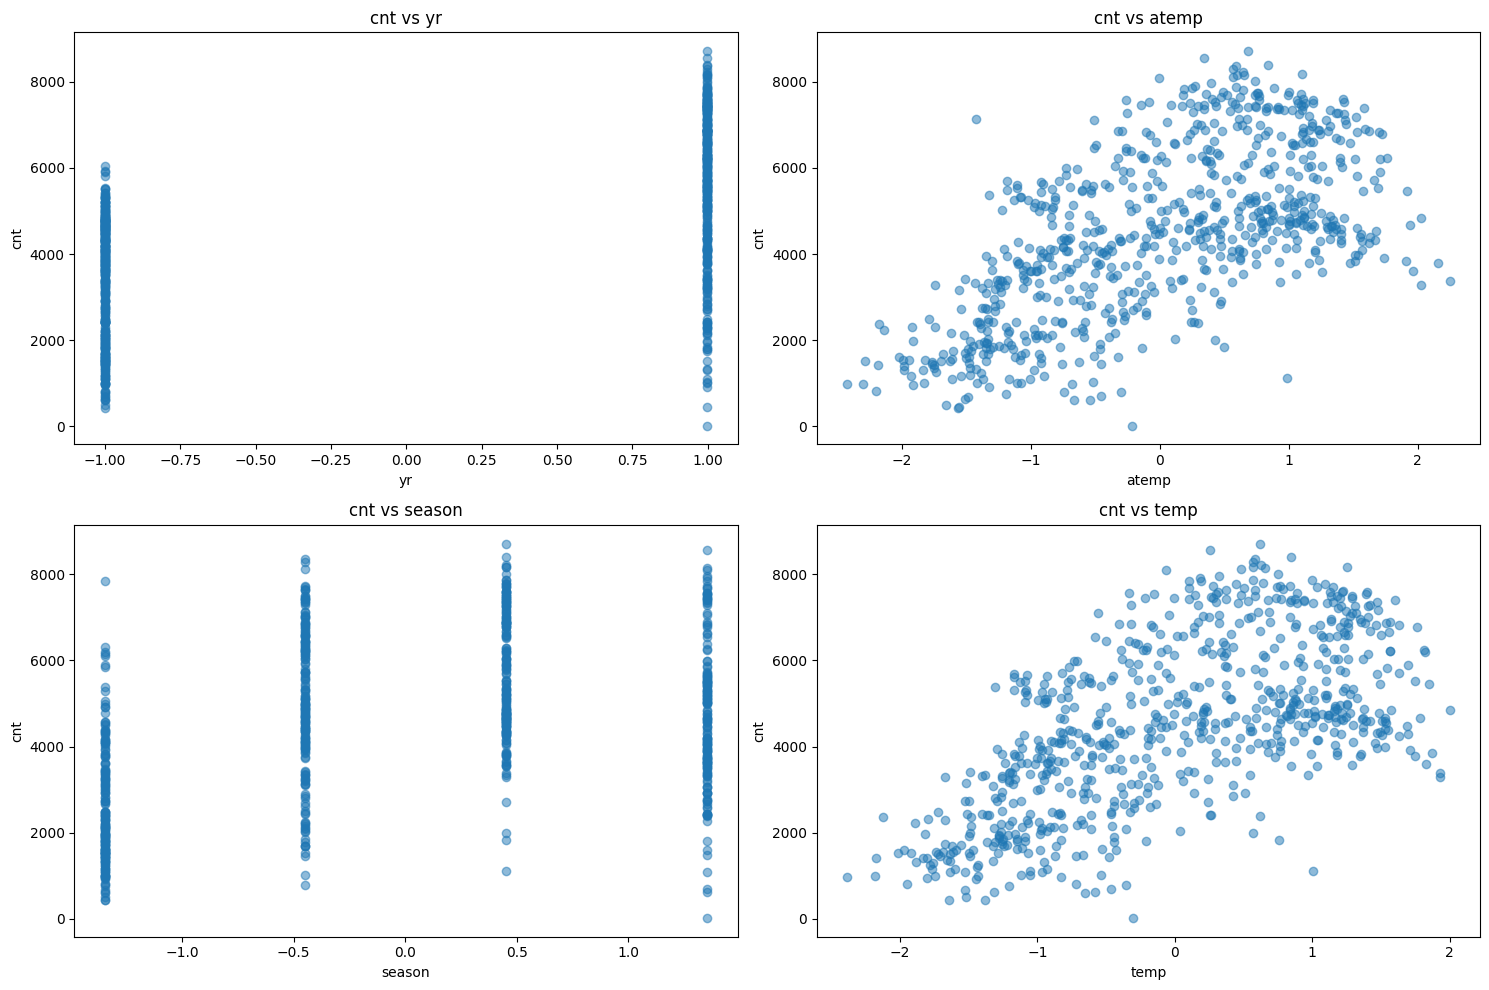

In [92]:
# Вибір чотирьох ознак з найбільшими позитивними коефіцієнтами
print(coefficients.items())
top_features = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)[:4]
print("Топ-4 функції з найбільшими позитивними коефіцієнтами:")
for feature, coef in top_features:
    print(f"Feature: {feature}, Coefficient: {coef}")

# Отримання числових індексів чотирьох ознак з найбільшими позитивними коефіцієнтами
top_features_indices = sorted(range(len(model.coef_)), key=lambda i: model.coef_[i], reverse=True)[:4]
# Отримання імен ознак за їхніми числовими індексами
top_features_names = [X_df.columns[i] for i in top_features_indices]


# Побудова графіків залежності cnt від вибраних ознак
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features_names, start=1):
    plt.subplot(2, 2, i)
    plt.scatter(X_df.loc[:, feature], y, alpha=0.5)
    plt.title(f"cnt vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("cnt")
plt.tight_layout()
plt.show()

На основі графіків можна зробити наступні спостереження:

Залежність кількості велосипедів від ознаки "temp" (температура) має вид лінійної залежності: чим вища температура, тим більше людей беруть велосипеди.
Аналогічно, для ознак "atemp" (відчутна температура) і "yr" (рік) також спостерігається зростаюча лінійна залежність: коли відчутна температура або рік зростає, кількість орендованих велосипедів також збільшується.
Ознака "hum" (вологість) має зворотну залежність: коли вологість зростає, кількість орендованих велосипедів зменшується.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

dict_items([('season', 560.2416160308861), ('yr', 1019.4634940657196), ('mnth', -128.73062703678696), ('holiday', -86.15278133371106), ('weekday', 137.34789390496314), ('workingday', 55.21237064135668), ('weathersit', -332.3698569623487), ('temp', 376.3632362096943), ('atemp', 576.530793504555), ('hum', -144.12915500348583), ('windspeed(mph)', -197.1396894024843), ('windspeed(ms)', -2.8051404183533485e-08)])
Топ-3 функції з найбільшими абсолютними негативними коефіцієнтами:
Feature: holiday, Coefficient: -86.15278133371106
Feature: workingday, Coefficient: 55.21237064135668
Feature: windspeed(ms), Coefficient: -2.8051404183533485e-08


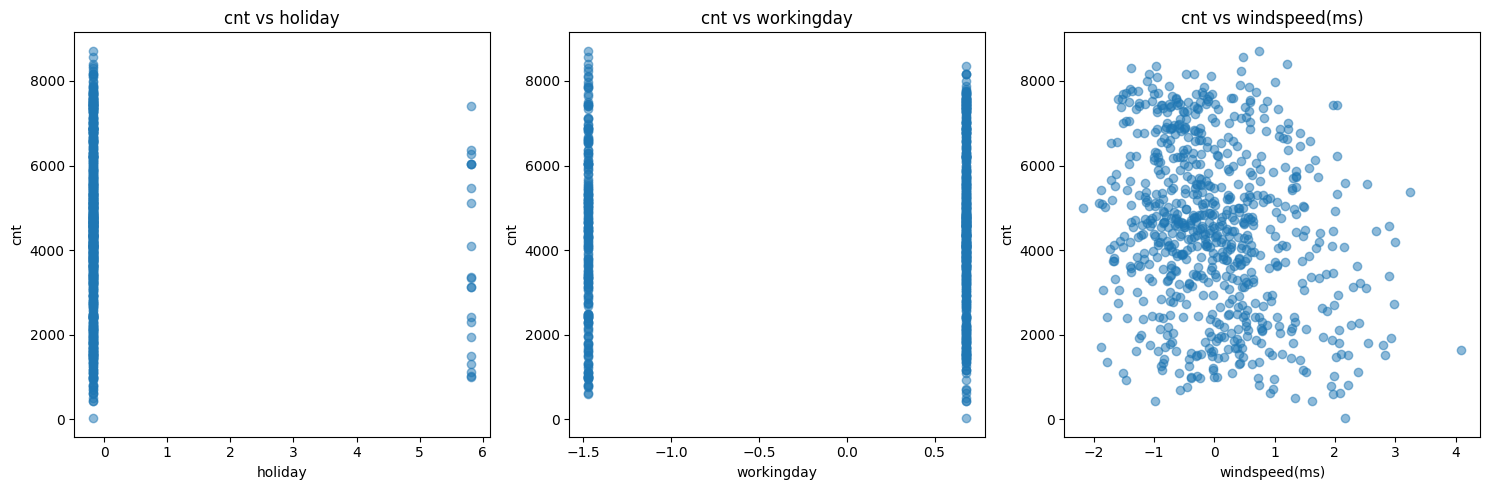

In [93]:
# Вибір трьох ознак з найбільшими за модулем негативними коефіцієнтами
print(coefficients.items())
top_negative_features = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)[-3:]

print("Топ-3 функції з найбільшими абсолютними негативними коефіцієнтами:")
for feature, coef in top_negative_features:
    print(f"Feature: {feature}, Coefficient: {coef}")

# Побудова графіків залежності cnt від обраних ознак
plt.figure(figsize=(15, 5))
for i, (feature, coef) in enumerate(top_negative_features, start=1):
    plt.subplot(1, 3, i)
    plt.scatter(X_df[feature], y, alpha=0.5)
    plt.title(f"cnt vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("cnt")
plt.tight_layout()
plt.show()

In [55]:
coefficients.items()

dict_items([('season', 560.2416160308861), ('yr', 1019.4634940657196), ('mnth', -128.73062703678696), ('holiday', -86.15278133371106), ('weekday', 137.34789390496314), ('workingday', 55.21237064135668), ('weathersit', -332.3698569623487), ('temp', 376.3632362096943), ('atemp', 576.530793504555), ('hum', -144.12915500348583), ('windspeed(mph)', -197.1396894024843), ('windspeed(ms)', -2.8051404183533485e-08)])

На основі графіків ми можемо зробити наступні спостереження:

Якщо ознака має негативний коефіцієнт, то зменшення значення цієї ознаки супроводжується зменшенням кількості орендованих велосипедів.
Лінійна залежність може не бути такою явною, як у випадку позитивних коефіцієнтів, але загальний тенденція зменшення кількості орендованих велосипедів при зростанні значення цих ознак все ще спостерігається.
Отже, можна логічно припустити, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [94]:
# Випишемо ознаки з коефіцієнтами, близькими до нуля
print(coefficients.items())
near_zero_features = {feature: coef for feature, coef in coefficients.items() if abs(coef) < 1e-3}
print("Features with coefficients close to zero:")
for feature, coef in near_zero_features.items():
    print(f"Feature: {feature}, Coefficient: {coef}")

dict_items([('season', 560.2416160308861), ('yr', 1019.4634940657196), ('mnth', -128.73062703678696), ('holiday', -86.15278133371106), ('weekday', 137.34789390496314), ('workingday', 55.21237064135668), ('weathersit', -332.3698569623487), ('temp', 376.3632362096943), ('atemp', 576.530793504555), ('hum', -144.12915500348583), ('windspeed(mph)', -197.1396894024843), ('windspeed(ms)', -2.8051404183533485e-08)])
Features with coefficients close to zero:
Feature: windspeed(ms), Coefficient: -2.8051404183533485e-08


Щодо того, чому модель виключила ці ознаки із моделі, це може бути зумовлено наступним:

Недостатня інформативність: Ці ознаки можуть бути недостатньо інформативними для прогнозування цільової змінної. Модель може вважати, що вони не додають нічого значущого до прогнозування кількості орендованих велосипедів.
Мультиколінеарність: Ці ознаки можуть бути дуже схожими на інші ознаки, які вже включені в модель. Якщо ознаки мають сильну кореляцію між собою, модель може вибрати лише одну з них для включення в модель.
Шум: Значення цих ознак можуть бути дуже шумними або випадковими, що не має значення для прогнозування цільової змінної.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.

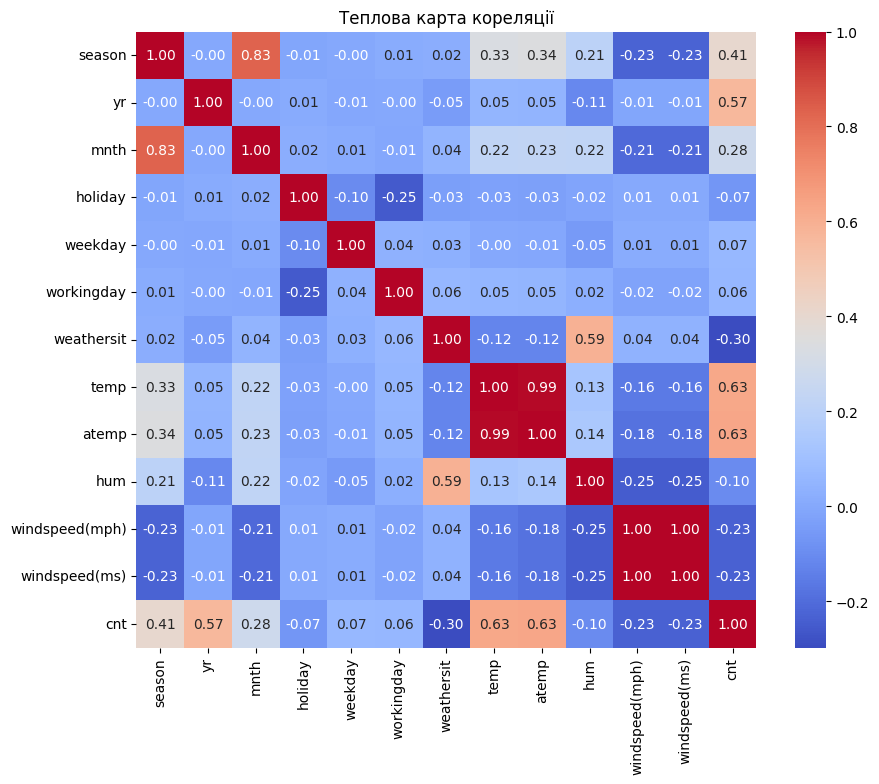

In [95]:
# Обчислення кореляції
correlation_matrix = df.corr()

# Побудова теплової карти кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Теплова карта кореляції')
plt.show()